In [1]:
import requests
import pandas as pd
from pandas import read_html
import matplotlib.pyplot as plt
import os.path
import numpy as np
import scipy.stats as stats
import matplotlib.dates as mdates
import math


In [2]:
def get_odstavky(df,od,do):
    indexes = df['Event Start']
    df.index= indexes
    dat = df

    dat.index = dat.index.astype('string').str.split('+',expand=True).droplevel(1)
    dat.index = pd.to_datetime(dat.index)

    dat['Event Start'] = dat['Event Start'].astype('string').str.split('+',expand=True).iloc[:,0]
    dat['Event Start'] = pd.to_datetime(dat['Event Start'])
    dat['Event Start'] = dat['Event Start'].round('H')
    dat['Event Stop'] = dat['Event Stop'].astype('string').str.split('+',expand=True).iloc[:,0]
    dat['Event Stop'] = pd.to_datetime(dat['Event Stop'])
    dat['Event Stop'] = dat['Event Stop'].round('H')

    dat['Odstavka'] = dat['Technical Capacity'] - dat['Available Capacity']

    lst = pd.date_range(start=od, end=do, freq='1D')

    # create new DataFrame
    df2 = pd.DataFrame(0, index=lst, columns=dat['Affected Asset or Unit'].unique())

    # loop over assets and dates and aggregate data for each day
    for col in df2.columns:
        for date in df2.index:
            mask = (dat['Event Start'] <= date) & (dat['Event Stop'] >= date) & (dat['Affected Asset or Unit'] == col)
            df2.loc[date, col] = dat.loc[mask]['Odstavka'].sum()

    # aggregate data for each day and add retrieved date
    df2['Odstavka'] = df2.sum(axis=1)
    df2 = df2[['Odstavka']]
    df2.index.name = 'Date'
    df2['Retrieved'] = pd.Timestamp.now().floor('D').strftime("%Y-%m-%d")
    return df2

In [3]:
s=requests.session()
s1=s.get("https://umm.gassco.no")
s2=s.get("https://umm.gassco.no/disclaimer/acceptDisclaimer?")
data = read_html(s2.text, attrs={"class": "msgTable"})
df = pd.DataFrame(data[0])
exit_terminals = pd.DataFrame(data[1])
start = "2023-01-01"
end = "2024-01-01"

In [6]:
# set file path and name
file_path = 'odstavky91.xlsx'

# check if file exists
if os.path.isfile(file_path):
    # read existing file
    existing_data = pd.read_excel(file_path)
    existing_data.set_index('Date', inplace=True)
    
    # check if last retrieved date is today
    last_date = pd.to_datetime(existing_data['Retrieved'].iloc[-1])
    today = pd.Timestamp.now().floor('D')
    
    if last_date == today:
        # do nothing
        data = existing_data
        pass
    else:
        # download new data
        new_data = get_odstavky(df, start, end)
        
        # append new data to existing file
        updated_data = existing_data.append(new_data)
        updated_data.to_excel(file_path)
        data = updated_data
else:
    # download new data and create new file
    new_data = get_odstavky(df, start, end)
    new_data.to_excel(file_path)
    data = new_data


In [32]:
DATES = data['Retrieved'].unique().tolist()
DATES[1]

'2023-04-25'

In [8]:
data

,Date,Odstavka,Retrieved
0,2023-01-01,1.1,2023-04-21
1,2023-01-02,1.1,2023-04-21
2,2023-01-03,1.1,2023-04-21
3,2023-01-04,1.1,2023-04-21
4,2023-01-05,1.1,2023-04-21
...,...,...,...
727,2023-12-28,0.0,2023-04-25
728,2023-12-29,0.0,2023-04-25
729,2023-12-30,0.0,2023-04-25
730,2023-12-31,0.0,2023-04-25


In [13]:
group_data['Odstavka']

366    1.1
367    1.1
368    1.1
369    1.1
370    1.1
      ... 
727    0.0
728    0.0
729    0.0
730    0.0
731    0.0
Name: Odstavka, Length: 366, dtype: float64

2023-04-21
2023-04-25
2023-04-26


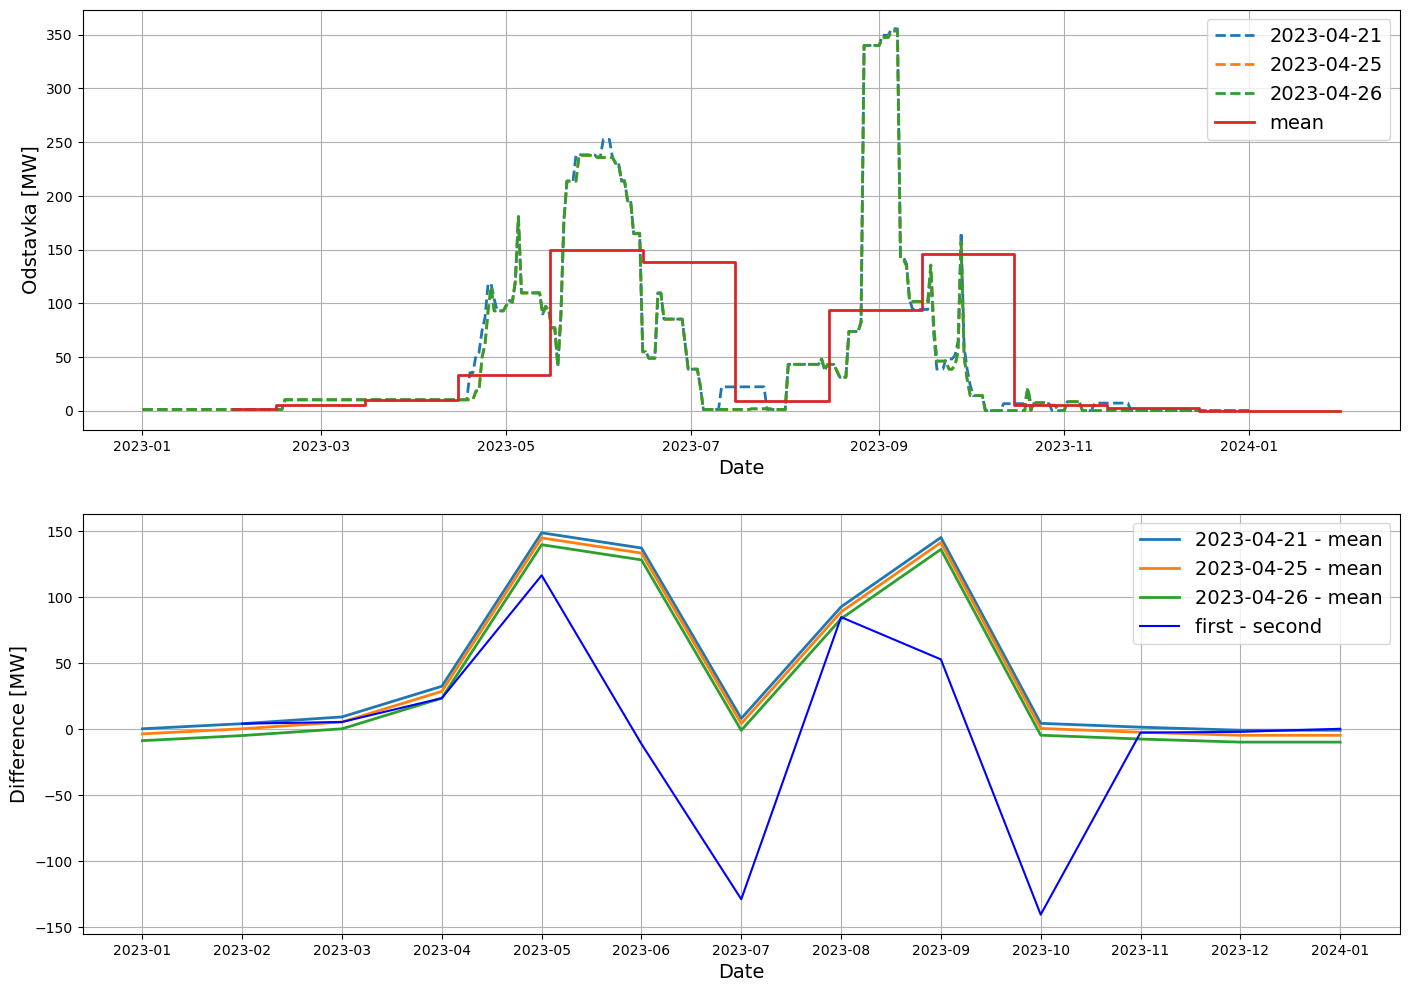

In [34]:

grouped = data.groupby(data['Retrieved'])
temp = pd.DataFrame()
DATES = data['Retrieved'].unique().tolist()

fig,(ax,axs)= plt.subplots(2,figsize=(17, 12))

for group_name, group_data in grouped:
    print(group_name)
    ax.plot(group_data.index, group_data['Odstavka'], label=group_name,linestyle = '--',linewidth=2)

grouped_data = data.groupby(pd.Grouper(freq='M')).agg({'Odstavka': 'mean'})

ax.step(grouped_data.index, grouped_data['Odstavka'], where='mid', linewidth=2, label='mean')
temp = data[['Retrieved', 'Odstavka']].groupby(data.index.strftime('%Y-%m')).mean()

# create a new figure
for i in range(data['Retrieved'].nunique()):
    diff = temp - temp.iloc[i]
    axs.plot(diff.index, diff['Odstavka'], label=DATES[i]+' - mean', linewidth=2)


# plot differences between both graphs
both_diff = data[['Retrieved', 'Odstavka']].groupby(data.index.strftime('%Y-%m')).mean().diff()
axs.plot(both_diff.index, both_diff['Odstavka'], color='blue', label='first - second')

# set labels, legend, and grid
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Odstavka [MW]', fontsize=14)
ax.legend(fontsize=14)
ax.grid(True)
axs.grid(True)
axs.set_xlabel('Date', fontsize=14)
axs.set_ylabel('Difference [MW]', fontsize=14)
axs.legend(fontsize=14)